# CIFAR-10 dataset classification with CNNs

Author: Tanwi Mallick, adapting codes from Bethany Lusch, Prasanna Balprakash, Corey Adams, and Kyle Felker

In this notebook, we'll continue the CIFAR-10 problem using the Keras API (as included in the TensorFlow library) and incorporating convolutional layers.

First, the needed imports.

In [1]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

## CIFAR-10 data set

Again we'll load the cifar10 data set. CIFAR-10 dataset contains 32x32 color images from 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. If you haven't downloaded it already, it could take a while.

In [2]:
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
from image_dataset_loader import load
(x_train, y_train), (x_test, y_test) = load('cifar10', ['train', 'test'])

x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

This time we won't flatten the images. 

The training data (`X_train`) is a 3rd-order tensor of size (50000, 32, 32), i.e. it consists of 50000 images of size 32x32 pixels. 

`y_train` is a 50000-dimensional vector containing the correct classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') for each training sample.

## Convolutional neural network (CNN)

CNN is a type of deep learning model for processing data that has a grid pattern, such as images.

Let's use a small model that includes convolutional layers

- The Conv2D layers operate on 2D matrices so we input the images directly to the model.
    - The two Conv2D layers below learn 32 and 64 filters respectively. 
    - They are learning filters for 3x3 windows.
- The MaxPooling2D layer reduces the spatial dimensions, that is, makes the image smaller.
    - It downsamples by taking the maximum value in the window 
    - The pool size of (2, 2) below means the windows are 2x2. 
    - Helps in extracting important features and reduce computation
- The Flatten layer flattens the 2D matrices into vectors, so we can then switch to Dense layers as in the MLP model.

See https://keras.io/layers/convolutional/, https://keras.io/layers/pooling/ for more information.

![conv layer](images/conv_layer.png)
Image credit: [Jason Brownlee](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)

![conv layer](images/conv.png)
Image credit: [Anh H. Reynolds](https://anhreynolds.com/blogs/cnn.html)


<img src="images/MaxpoolSample2.png" width="600" hight="600" align="left"/>

In [91]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        #self.pool_1a = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv_2 = tf.keras.layers.Conv2D(128, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        
        #self.conv_2a = tf.keras.layers.Conv2D(128, [3, 3], activation='relu')
        #self.pool_3a = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        
        self.drop_4 = tf.keras.layers.Dropout(0.1)
        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.1)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        #x = self.pool_1a(x)
        x = self.conv_2(x)
        x = self.pool_3(x)
        
        #x = self.conv_2a(x)
        #x = self.pool_3a(x)
        
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

### Simple training

Here is a concise way to train the network, like we did in the previous notebook. We'll see a more verbose approach below that allows more performance tuning.

In [92]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [93]:
# This took 43 seconds per epoch on my laptop
batch_size = 256
epochs = 5
lr = .05
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/5
196/196 [==============================] - 2s 6ms/step - loss: 1.5403 - accuracy: 0.4451
Epoch 2/5
196/196 [==============================] - 1s 6ms/step - loss: 1.1357 - accuracy: 0.5996
Epoch 3/5
196/196 [==============================] - 1s 6ms/step - loss: 0.9753 - accuracy: 0.6592
Epoch 4/5
196/196 [==============================] - 1s 6ms/step - loss: 0.8731 - accuracy: 0.6945
Epoch 5/5
196/196 [==============================] - 1s 6ms/step - loss: 0.7864 - accuracy: 0.7245


Accuracy for test data.  The model should be better than the non-convolutional model even if you're only patient enough for three epochs. 

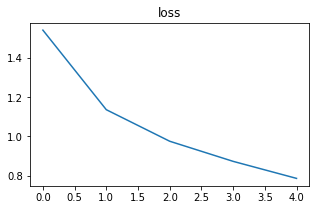

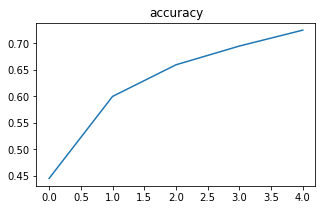

In [94]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

With enough training epochs, the test accuracy should exceed 96.53%.

You can compare your result with the state-of-the art [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html). 

In [95]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 0s - loss: 0.8888 - accuracy: 0.6921 - 420ms/epoch - 1ms/step
accuracy: 69.21%
CPU times: user 660 ms, sys: 179 ms, total: 839 ms
Wall time: 533 ms


We can also again check the confusion matrix

In [96]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

313/313 [==============================] - 0s 854us/step
[[732  19  50  23   5   6   7   7 104  47]
 [ 16 811   5   8   0   5   7   2  39 107]
 [ 82  11 534  71  65  97  55  50  17  18]
 [ 17  15  60 541  31 193  62  26  29  26]
 [ 34   4  99 124 505  50  58  94  26   6]
 [ 16   2  53 166  27 641  18  43  19  15]
 [  7  11  47  59  10  44 794   5  16   7]
 [ 21   4  33  56  32  80   5 738   6  25]
 [ 70  46   7  12   2   6   5   2 812  38]
 [ 27  81   5  19   1   6   4  12  32 813]]

Classification accuracy for each class:

0: 0.7320
1: 0.8110
2: 0.5340
3: 0.5410
4: 0.5050
5: 0.6410
6: 0.7940
7: 0.7380
8: 0.8120
9: 0.8130


# Homework: improve the accuracy of this model

Update this notebook to ensure more accuracy. How high can it be raised? Changes like increasing the number of epochs, altering the learning rate, altering the number of neurons the hidden layer, chnaging the optimizer, etc. could be made directly in the notebook. You can also change the model specification by expanding the network's layer. The current notebook's training accuracy is roughly 58.06%, although it varies randomly.

## solution

1) Decreasing the dropout ratio to 0.1 increased accuracy to ~63%.

2) Adding a max pool layer after the first layer did not help.

3) Adding one more convolutional layer with 128 filters, with or without max pooling did not help.

4) Changing the filters to 64 and 128 at the first two layers also does not work.

5) Increasing the learning rate to 0.1 doesn't improve the accuracy much.

6) Decreasing the batch size to 128 gives only a marginal improvement.

7) Using stochastic gradient descent is much worse.

### 8) Finally, I simply increase no. of epochs to 5 to get an accuracy of 72%. This can be carried on for more epochs.